In [1]:
import pandas as pd

In [2]:
# pd.read_hdf('clean_data.h5')
with pd.HDFStore('clean_data.h5') as hdf:
    print( hdf.keys() )

['/media', '/media_merged', '/obs', '/obs2']


In [3]:
media_df = pd.read_hdf('clean_data.h5', '/media')

In [4]:
media_df.columns.tolist()

['gbifID', 'format', 'identifier']

In [5]:
media_df.shape

(2803519, 3)

# AWS Rekognition
* Uses [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)

In [6]:
import boto3
rek_client = boto3.client('rekognition')

## Pricing

In [7]:
image_total = media_df.shape[0]
dollar_total = 0
if image_total > 1000000:
    dollar_total += 1000000 * 0.001
    image_total -= 1000000
    if image_total > 4000000:
        dollar_total += 4000000 * 0.0008
        image_total -= 4000000
    else:
        dollar_total += image_total * 0.0008
else:
    dollar_total += image_total * 0.001

print(f'Rekognition - Detect Labels cost for entire dataset ({media_df.shape[0]} images) ${dollar_total}')


Rekognition - Detect Labels cost for entire dataset (2803519 images) $2442.8152


## Save images to S3
* only use 1000 images as sample

In [8]:
sample = media_df.sample(1000, random_state=42)

In [9]:
s3_client = boto3.client('s3')
bucket_name = 'fungi-sample'

# Create bucket if it doesn't already exist
try:
    s3_client.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint': 'us-west-1',
        },
    )
except s3_client.exceptions.BucketAlreadyOwnedByYou:
    print('Bucket already exists and is owned by you.')
except s3_client.exceptions.BucketAlreadyExists:
    print("Bucket already exists")

Bucket already exists and is owned by you.


In [10]:
media_df.head()

,gbifID,format,identifier
0,891021265,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...
1,891023450,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...
2,891023450,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...
3,891023450,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...
4,891023450,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...


In [11]:
import requests

sample['index'] = sample.index

In [12]:
sample.apply( lambda row: print(row), axis=1)

gbifID                                               3802422358
format                                               image/jpeg
identifier    https://inaturalist-open-data.s3.amazonaws.com...
index                                                    456299
Name: 456299, dtype: object
gbifID                                               3915328216
format                                               image/jpeg
identifier    https://inaturalist-open-data.s3.amazonaws.com...
index                                                   2197584
Name: 2197584, dtype: object
gbifID                                               2518145019
format                                               image/jpeg
identifier    https://inaturalist-open-data.s3.amazonaws.com...
index                                                    664976
Name: 664976, dtype: object
gbifID                                               3343850287
format                                               image/jpeg
identifier    https

456299     None
2197584    None
664976     None
2554511    None
1919353    None
           ... 
2448314    None
1243055    None
399087     None
483504     None
19588      None
Length: 1000, dtype: object

In [13]:
def upload_image( url, index ):
    print(f'{index} {url}')
    r = requests.get( url, stream=True )
    s3_client.upload_fileobj(
        r.raw,
        Bucket=bucket_name,
        Key=str(index)
    )

# Removing image upload - already performed to a suitable extent
# sample.apply(
#     lambda row: upload_image(
#         row['identifier'],
#         row['index'],
#     ), 
#     axis=1,
# )

### Notes
* Image upload to S3 is fairly slow using 'apply' - parallelize?
* Rekognition seems to be cost prohibitive

In [14]:
# get list of images that have been uploaded to S3 bucket
s3_images = s3_client.list_objects_v2(
    Bucket=bucket_name,
)
s3_images_df = pd.DataFrame(s3_images['Contents'])

# drop unnecessary columns
s3_images_df = s3_images_df.drop( [
    'LastModified',
    'ETag',
    'Size',
    'StorageClass',
], axis=1)

s3_images_df.head()

,Key
0,130684
1,1580934
2,1591270
3,1629329
4,1765041


## Label detection

In [15]:
s3_images_df.columns

Index(['Key'], dtype='object')

In [16]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# get labels for each image and add to sample DataFrame
def get_labels( bucket_name, row, included_labels ):
    
    print(row['Key'])

    # query the cloud API - AWS Rekognition
    label_response = rek_client.detect_labels(
        Image={
            # 'Bytes': b'bytes',
            'S3Object': {
                'Bucket': bucket_name,
                'Name': row['Key'],
                # 'Version': 'string',
            },
        },
        MaxLabels=20,
        Settings={
            'GeneralLabels': {
                'LabelInclusionFilters': included_labels,
            },
            # can also specifiy label exclusion list and category
            # (such as 'Plants and Flowers') for inclusion/exclusion
        }
    )['Labels']
    
    label_response_dict = {
        'aws': {
            'rek': {
                'labels': {
                },
            }
        }
    }
    
    for label_dict in label_response:
        label_response_dict['aws']['rek']['labels'][label_dict['Name']] = label_dict
        del label_response_dict['aws']['rek']['labels'][label_dict['Name']]['Parents']
        del label_response_dict['aws']['rek']['labels'][label_dict['Name']]['Aliases']
        del label_response_dict['aws']['rek']['labels'][label_dict['Name']]['Categories']
        del label_response_dict['aws']['rek']['labels'][label_dict['Name']]['Name']
    
    label_df = pd.json_normalize(label_response_dict)
    label_df['Key'] = row['Key']

    return label_df.iloc[0]

# s3_images_labels_df = s3_images_df.head(10).apply(
s3_images_labels_df = s3_images_df.apply(
    lambda row: get_labels(
        bucket_name,
        row,
        included_labels = [
            'Fungus',
            'Mushroom',
        ],
    ),
    axis=1,
)

s3_images_labels_df = s3_images_labels_df.set_index('Key')

s3_images_labels_df


130684
1580934
1591270
1629329
1765041
1771493
1861660
1919353
2197584
2232852
2376098
2394955
2530881
2541977
255448
2554511
2618667
348968
368229
456299
664976
673502
82301
976253


,aws.rek.labels.Fungus.Confidence,aws.rek.labels.Fungus.Instances,aws.rek.labels.Mushroom.Confidence,aws.rek.labels.Mushroom.Instances
Key,,,,
130684,99.586273,"[{'BoundingBox': {'Width': 0.502346932888031, 'Height': 0.5833670496940613, 'Left': 0.2507229447364807, 'Top': 0.2732160687446594}, 'Confidence': 99.58627319335938}]",87.923698,[]
1580934,85.806229,[],69.750076,[]
1591270,93.320786,[],90.840820,[]
1629329,94.964264,"[{'BoundingBox': {'Width': 0.8810873031616211, 'Height': 0.6152558922767639, 'Left': 0.026099685579538345, 'Top': 0.15263591706752777}, 'Confidence': 87.4364242553711}]",90.341286,[]
1765041,98.687599,"[{'BoundingBox': {'Width': 0.8805204033851624, 'Height': 0.867842972278595, 'Left': 0.04958786070346832, 'Top': 0.08853685855865479}, 'Confidence': 98.6875991821289}]",90.983238,[]
1771493,NaN,NaN,NaN,NaN
1861660,97.075699,"[{'BoundingBox': {'Width': 0.26986002922058105, 'Height': 0.6264593601226807, 'Left': 0.5174733400344849, 'Top': 0.17786163091659546}, 'Confidence': 68.50355529785156}]",96.833374,[]
1919353,99.937210,"[{'BoundingBox': {'Width': 0.8131828308105469, 'Height': 0.7992454767227173, 'Left': 0.10619636625051498, 'Top': 0.06041530892252922}, 'Confidence': 99.93721008300781}]",86.333237,[]
2197584,83.535286,[],72.561554,[]


In [17]:
s3_images_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 130684 to 976253
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   aws.rek.labels.Fungus.Confidence    22 non-null     float64
 1   aws.rek.labels.Fungus.Instances     22 non-null     object 
 2   aws.rek.labels.Mushroom.Confidence  21 non-null     float64
 3   aws.rek.labels.Mushroom.Instances   21 non-null     object 
dtypes: float64(2), object(2)
memory usage: 960.0+ bytes


In [18]:
s3_images_labels_df.shape

(24, 4)

### Label analysis

In [19]:
label_nans = s3_images_labels_df[ s3_images_labels_df.isna().any(axis=1) ]
label_nans

,aws.rek.labels.Fungus.Confidence,aws.rek.labels.Fungus.Instances,aws.rek.labels.Mushroom.Confidence,aws.rek.labels.Mushroom.Instances
Key,,,,
1771493,NaN,NaN,NaN,NaN
255448,55.199596,[],NaN,NaN
456299,NaN,NaN,NaN,NaN


In [20]:
from IPython.display import Image, display

images = []
for key in label_nans.index:
    images.append(Image(url=f'https://fungi-sample.s3.us-west-1.amazonaws.com/{key}', format='jpg'))
    
print("These images have one or more labels undetected (of the sample dataset):")
display(*images)

These images have one or more labels undetected (of the sample dataset):


array([[<AxesSubplot: title={'center': 'aws.rek.labels.Fungus.Confidence'}>,
        <AxesSubplot: title={'center': 'aws.rek.labels.Mushroom.Confidence'}>]],
      dtype=object)

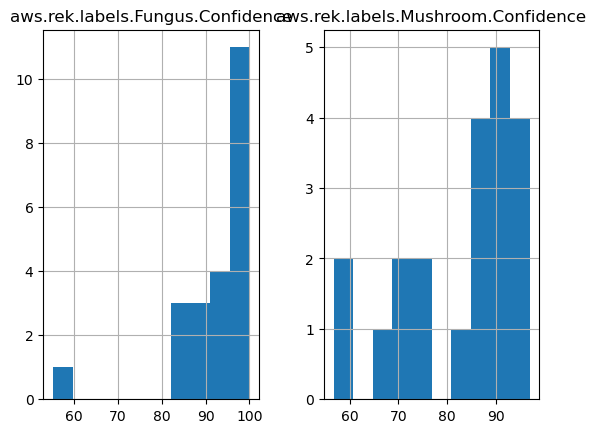

In [21]:
# Confidence distribution

# fill NaNs with 0.0
# s3_images_labels_df['aws.rek.labels.Fungus.Confidence'] = s3_images_labels_df['aws.rek.labels.Fungus.Confidence'].fillna(0.0)
# s3_images_labels_df['aws.rek.labels.Mushroom.Confidence'] = s3_images_labels_df['aws.rek.labels.Mushroom.Confidence'].fillna(0.0)

s3_images_labels_df[[
    'aws.rek.labels.Fungus.Confidence',
    'aws.rek.labels.Mushroom.Confidence',
]].hist()

In [22]:
# Bounding Box exploration

## Fill NaN values for Instances with empty json array
# s3_images_labels_df['aws.rek.labels.Fungus.Instances'] = s3_images_labels_df['aws.rek.labels.Fungus.Instances'].fillna(list())
# s3_images_labels_df['aws.rek.labels.Mushroom.Instances'] = s3_images_labels_df['aws.rek.labels.Mushroom.Instances'].fillna(list())


In [23]:
# Lets look at counts of Instances for each label

import json
import numpy as np

s3_images_labels_df['Key'] = s3_images_labels_df.index

def get_label_instance_counts( row ):
    print(row['Key'])
    
    fungus_instances = row.get('aws.rek.labels.Fungus.Instances')
    mushroom_instances = row.get('aws.rek.labels.Mushroom.Instances')
    
    if (type(fungus_instances) == list):
        row['aws.rek.labels.Fungus.Instances.count'] = len(fungus_instances)
        
    if (type(mushroom_instances) == list):
        row['aws.rek.labels.Mushroom.Instances.count'] = len(mushroom_instances)
    
    return row

s3_images_labels_df = s3_images_labels_df.apply(
    get_label_instance_counts,
    axis=1,
)

instance_counts = s3_images_labels_df.filter(regex='count$')

130684
1580934
1591270
1629329
1765041
1771493
1861660
1919353
2197584
2232852
2376098
2394955
2530881
2541977
255448
2554511
2618667
348968
368229
456299
664976
673502
82301
976253


array([[<AxesSubplot: title={'center': 'aws.rek.labels.Fungus.Instances.count'}>,
        <AxesSubplot: title={'center': 'aws.rek.labels.Mushroom.Instances.count'}>]],
      dtype=object)

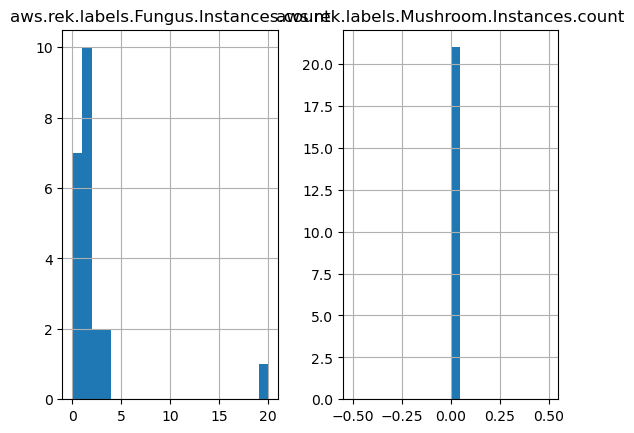

In [24]:
instance_counts.hist(bins=20)

In [25]:
percent = 100 * (instance_counts['aws.rek.labels.Fungus.Instances.count'] == 0).sum() / len(instance_counts)
print(f"Percentage of images with 0 bounding boxes for the 'Fungus' label: {percent}")

Percentage of images with 0 bounding boxes for the 'Fungus' label: 29.166666666666668


### Conclusion
Fairly decent results on the sample data (24). Would be interesting to see results on a larger sample size.

Unfortunately there are no bounding boxes available for the "Mushroom" label (for some reason?) and while there are some bounding boxes for the "Fungus" label, there are a significant number (29.2%) that do not have any (which may or may not mean anything).

## Image properties
In addition to object label detection, AWS Rekognition provides image property labels - lets see what our dataset produces

In [26]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

def get_image_property_labels( bucket_name, row ):
    print(row['Key'])
    
    label_response = rek_client.detect_labels(
        # query IMAGE_PROPERTIES instead of GENERAL_LABELS (both can be retrieved in one query, if desired)
        Features=['IMAGE_PROPERTIES'],
        Image={
            'S3Object': {
                'Bucket': bucket_name,
                'Name': row['Key'],
            },
        },
    )['ImageProperties']
    
    # reframe dict to add prefix to columns to help differentiate columns from other queries
    label_response = {
        'aws': {
            'rek': {
                'ip': label_response
            }
        }
    }

    # label_response keys include ['Quality', 'DominantColors', 'Foreground', 'Background']
    
    # convert to Series and add key to dictionary
    label_response['Key'] = row['Key']
    label_response = pd.json_normalize(
        label_response,
    ).iloc[0]
    print(label_response)
    
    return label_response

s3_images_ip_df = s3_images_df.head(1).apply(
    lambda row: get_image_property_labels( 'fungi-sample', row ),
    axis=1
)

s3_images_ip_df = s3_images_ip_df.set_index('Key')

s3_images_ip_df.head()


130684
Key                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

,aws.rek.ip.Quality.Brightness,aws.rek.ip.Quality.Sharpness,aws.rek.ip.Quality.Contrast,aws.rek.ip.DominantColors,aws.rek.ip.Foreground.Quality.Brightness,aws.rek.ip.Foreground.Quality.Sharpness,aws.rek.ip.Foreground.DominantColors,aws.rek.ip.Background.Quality.Brightness,aws.rek.ip.Background.Quality.Sharpness,aws.rek.ip.Background.DominantColors
Key,,,,,,,,,,
130684,52.143394,81.717384,84.677025,"[{'Red': 0, 'Blue': 0, 'Green': 0, 'HexCode': '#000000', 'CSSColor': 'black', 'SimplifiedColor': 'black', 'PixelPercent': 36.872310638427734}, {'Red': 85, 'Blue': 47, 'Green': 107, 'HexCode': '#556b2f', 'CSSColor': 'darkolivegreen', 'SimplifiedColor': 'green', 'PixelPercent': 23.098995208740234}, {'Red': 47, 'Blue': 79, 'Green': 79, 'HexCode': '#2f4f4f', 'CSSColor': 'darkslategrey', 'SimplifiedColor': 'grey', 'PixelPercent': 22.71640396118164}, {'Red': 192, 'Blue': 192, 'Green': 192, 'HexCode': '#c0c0c0', 'CSSColor': 'silver', 'SimplifiedColor': 'grey', 'PixelPercent': 10.99952220916748}, {'Red': 205, 'Blue': 63, 'Green': 133, 'HexCode': '#cd853f', 'CSSColor': 'peru', 'SimplifiedColor': 'brown', 'PixelPercent': 3.3476805686950684}, {'Red': 107, 'Blue': 35, 'Green': 142, 'HexCode': '#6b8e23', 'CSSColor': 'olivedrab', 'SimplifiedColor': 'green', 'PixelPercent': 2.965088367462158}]",85.302513,75.852539,"[{'Red': 192, 'Blue': 192, 'Green': 192, 'HexCode': '#c0c0c0', 'CSSColor': 'silver', 'SimplifiedColor': 'grey', 'PixelPercent': 42.767295837402344}, {'Red': 188, 'Blue': 143, 'Green': 143, 'HexCode': '#bc8f8f', 'CSSColor': 'rosybrown', 'SimplifiedColor': 'brown', 'PixelPercent': 23.27044105529785}, {'Red': 169, 'Blue': 169, 'Green': 169, 'HexCode': '#a9a9a9', 'CSSColor': 'darkgrey', 'SimplifiedColor': 'grey', 'PixelPercent': 11.635220527648926}, {'Red': 128, 'Blue': 128, 'Green': 128, 'HexCode': '#808080', 'CSSColor': 'gray', 'SimplifiedColor': 'grey', 'PixelPercent': 9.748427391052246}, {'Red': 160, 'Blue': 45, 'Green': 82, 'HexCode': '#a0522d', 'CSSColor': 'sienna', 'SimplifiedColor': 'brown', 'PixelPercent': 7.2327046394348145}, {'Red': 210, 'Blue': 140, 'Green': 180, 'HexCode': '#d2b48c', 'CSSColor': 'tan', 'SimplifiedColor': 'brown', 'PixelPercent': 2.2012579441070557}, {'Red': 47, 'Blue': 79, 'Green': 79, 'HexCode': '#2f4f4f', 'CSSColor': 'darkslategrey', 'SimplifiedColor': 'grey', 'PixelPercent': 1.5723270177841187}, {'Red': 0, 'Blue': 0, 'Green': 0, 'HexCode': '#000000', 'CSSColor': 'black', 'SimplifiedColor': 'black', 'PixelPercent': 0.9433962106704712}, {'Red': 85, 'Blue': 47, 'Green': 107, 'HexCode': '#556b2f', 'CSSColor': 'darkolivegreen', 'SimplifiedColor': 'green', 'PixelPercent': 0.6289308071136475}]",46.605404,82.608383,"[{'Red': 0, 'Blue': 0, 'Green': 0, 'HexCode': '#000000', 'CSSColor': 'black', 'SimplifiedColor': 'black', 'PixelPercent': 43.66608428955078}, {'Red': 47, 'Blue': 79, 'Green': 79, 'HexCode': '#2f4f4f', 'CSSColor': 'darkslategrey', 'SimplifiedColor': 'grey', 'PixelPercent': 26.911849975585938}, {'Red': 85, 'Blue': 47, 'Green': 107, 'HexCode': '#556b2f', 'CSSColor': 'darkolivegreen', 'SimplifiedColor': 'green', 'PixelPercent': 12.901342391967773}, {'Red': 0, 'Blue': 0, 'Green': 100, 'HexCode': '#006400', 'CSSColor': 'darkgreen', 'SimplifiedColor': 'green', 'PixelPercent': 8.639813423156738}, {'Red': 107, 'Blue': 35, 'Green': 142, 'HexCode': '#6b8e23', 'CSSColor': 'olivedrab', 'SimplifiedColor': 'green', 'PixelPercent': 3.502626895904541}, {'Red': 205, 'Blue': 63, 'Green': 133, 'HexCode': '#cd853f', 'CSSColor': 'peru', 'SimplifiedColor': 'brown', 'PixelPercent': 3.3858728408813477}, {'Red': 128, 'Blue': 0, 'Green': 0, 'HexCode': '#800000', 'CSSColor': 'maroon', 'SimplifiedColor': 'brown', 'PixelPercent': 0.9924109578132629}]"


### Conclusion
Useful information from this API call could be overall dominant colors and foreground dominant colors. More investigation may be necessary to determine usefulness.

Might prove more useful if used on the bounding box-based cropped image of the 'Fungus' or 'Mushroom' label produced during Label Detection to yield a 'mushroom color' property of sorts.